# Spike Triggered Average (STA)

So far, we have familiarised ourselves with alligning of spike trains to stimulus, binning them and calculating the firing rate. Today, you will try to predict the response of cells to a new kind of visual stimulus, and in the process build your first model - the linear-nonlinear (LN) model. But before you can start working on the model itself, you will need to compute the spike triggered average (STA) for each cell.

The STA represents the sequence of stimuli that make a cell happy (and cause it to fire). The more similar the stimulus is to the cell's STA, the more the cell will fire. This is why you need it to predict the cell's responses to stimuli.

**To compute the STA, you will need to:**

* Load and align the stimulus and pulses
* Collect snippets of the stimulus preceding each spike
* Find the average stimulus that evokes spiking

First, let's import the packages we will need:

In [1]:
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 6), 'font.size': 14 }

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
### HELPER FUNCTIONS ###
# Please run this cell #
# before starting with #
#     the notebook     #
########################


def plot_rasters(
    response_matrix: np.ndarray,
    ax: plt.Axes,
    sampling_rate: float,
    **kwargs
):
    for t, trial in enumerate(response_matrix):
        spike_list = []
        for c, spike_count in enumerate(trial):
            if spike_count > 0:
                spike_list.extend((np.random.random(size=spike_count) + c).tolist())

        if spike_list:
            ax.plot(
                np.array(spike_list) / sampling_rate,
                [1 + t] * len(spike_list),
                **kwargs
            )
    ax.invert_yaxis()

    return ax

# 1 - Full-field Flicker stimulus

The data you are going to work with comes from multielectrode-array recordings of retinal ganglion cells that were stimulated with a full-field flicker stimulus. The full-field flicker consists of a screen-wide presentation of contrast levels that change with a given frequency (here 75Hz). The contrast value of each presentation is calculated from a number that's been drawn from a Gaussian distribution of mean zero and standard deviation 0.3, with positive values representing brighter, negative values darker presentations.

This is what it looks like:

<img src="images/fff.gif" width="200">

The (reasonable) assumption here is that the stimulus seen by the cell just before it spiked is actually what caused it to spike. Hence, we are going to collect the sequences of contrast values that were presented in a fixed time window preceding **each spike** and average them. The result will be the spike-triggered average, i.e. the average stimulus that elicits a spike.

<center><img src="images/sta.png" width="600"></center>

# 2 - Load the stimulus

Let us first load the pulses (times of stimulus presentation), the stimulus values.

In [3]:
pulses_filepath = 'data_LN_model/frametimes_fullfieldnoise.txt'
pulses = np.loadtxt(pulses_filepath)

## Each pulse marks a change in stimulus presentation

In [4]:
stimulus_filepath = 'data_LN_model/stimulus_fullfieldnoise.txt'
stimulus = np.loadtxt(stimulus_filepath)

## Each value is a contrast value of the screen.

Let us take a look at the dimensions of `pulses` and `stimulus`.

In [5]:
print(pulses.shape)
print(stimulus.shape)

(100554,)
(101401,)


The stimulus shown to the retina consists of a **training set** and a **test set**. The **training set** will be used to compute the STA and tune the model's parameters so it learns to predict a cell's responses, while the **test set** will be used to evaluate the model's ability to predict that cell's responses to unseen stimuli.

The training set consists of randomly drawn contrast values from a Gaussian distribution (as mentioned before) and it **does not repeat in trials** whereas the test set consists of one sequence of randomly drawn contrast values that **remains the same across trials**. The test set is repeated in every trial to account for any variability, for eg. from experimental noise, that may arise in the cell's responses. The model will be evaluated on the average response of the cell to the test stimulus across trials.

<p><center><img src="images/FFFstimstructure.png" width="600" height="400"></center></p>

Each trial in our dataset contains 1800 training frames and 600 test frames. The `pulses` and `stimulus`, however, are simply long lists of numbers. You will need to reshape those lists to match the `(num_trials x num_frames)` sturcture of the presented stimulus.

**Exercise:** Reshape the values in `pulses` and `stimulus` into trials.

*Hint 1:* `pulses` and `stimulus` must have the same length, and the generated `stimulus` is longer than needed.

*Hint 2:* you'll need to compute the number of trials from the information you have so far.

In [6]:
nframes_training = 1800
nframes_test = 600

## START CODE HERE ##

# Make sure stimulus and pulses have the same length
stimulus = stimulus[:len(pulses)]

# Calculate the number of trials and reshape pulses accordingly
trial_frames = nframes_training + nframes_test
num_trials = int(np.floor(len(pulses) / trial_frames))

reshaped_pulses = pulses[:num_trials * trial_frames]
reshaped_pulses = np.reshape(reshaped_pulses, (num_trials, trial_frames))

reshaped_stimulus = stimulus[:num_trials * trial_frames]
reshaped_stimulus = np.reshape(reshaped_stimulus, (num_trials, trial_frames))

## END CODE HERE ##

Now let us check if your code is correct.

In [7]:
print(reshaped_pulses.shape)
print(reshaped_stimulus.shape)

(41, 2400)
(41, 2400)


**Expected output:**

```
(41, 2400)
(41, 2400)
```


In [8]:
print(reshaped_pulses[0, :10])  # first ten pulse timings
print(reshaped_pulses[-1, -10:]) # last ten pulse timings

[1.7499  1.76318 1.77658 1.78986 1.80322 1.81654 1.82986 1.84318 1.85658
 1.8699 ]
[1313.70406 1313.71738 1313.7307  1313.74398 1313.75738 1313.7707
 1313.78402 1313.79734 1313.81054 1313.82386]


**Expected output:** 

```
[1.7499  1.76318 1.77658 1.78986 1.80322 1.81654 1.82986 1.84318 1.85658
 1.8699 ]
[1313.70406 1313.71738 1313.7307  1313.74398 1313.75738 1313.7707
 1313.78402 1313.79734 1313.81054 1313.82386]
 ```


As an additional step, let us separate the training set and test set in both `pulses` and `stimulus`. 
This will help us later while calculating the STA.

In [9]:
pulses_training = reshaped_pulses[:, :nframes_training]
pulses_test = reshaped_pulses[:, nframes_training:]

stimulus_training = reshaped_stimulus[:, :nframes_training,]
stimulus_test = reshaped_stimulus[:, nframes_training:]

print(pulses_test.shape)
print(pulses_training.shape)

print(stimulus_test.shape)
print(stimulus_training.shape)

(41, 600)
(41, 1800)
(41, 600)
(41, 1800)


# 3 - Load the spike times

The `pulses` and `stimulus` are now organized into training and test sets. Let us now load the spiking activity of a single cell in response to the stimulus.

In [10]:
st_filepath = 'data_LN_model/fullfieldnoise_C1.txt'
spike_times = np.loadtxt(st_filepath)

In [11]:
print(spike_times.shape)

(23173,)


These are the time stamps (in seconds) of when the cell fired during the whole recording. Let us take a look at a few example spikes:

In [12]:
print(spike_times[:10])  # first ten spikes
print(spike_times[-10:])  # last ten spikes

[0.04168 0.39316 0.5116  0.52968 0.5374  0.54044 0.89976 0.94096 1.18
 1.1966 ]
[1342.54692 1342.74024 1342.76156 1342.81416 1342.98432 1343.29296
 1343.35504 1343.36744 1343.37776 1343.38464]


If you compare the first and last spike times with the first and last pulse timings from above, you'll notice that there are spikes were recorded before the first pulse and after the last pulse. We are interested in the spikes which occur only during the stimulus presentation.

**Exercise:** complete the code to remove the spikes that occur outside the stimulus presentation

* *Hint:* Use `array.ravel()` to work with a flattened version of the array in-line

In [13]:
stimulus_spiketimes = spike_times[  # select...
    ## COMPLETE CODE HERE
    
    # ... all spikes after the first pulse
    # ... and all spikes before the last pulse
]

SyntaxError: invalid syntax (4135623304.py, line 6)

In [14]:
## SOLUTION

stimulus_spiketimes = spike_times[  # select...
    (spike_times > reshaped_pulses.ravel()[0]) &  # ... all spikes after the first pulse
    (spike_times < reshaped_pulses.ravel()[-1])  # ... and all spikes before the last pulse
]

In [15]:
print(stimulus_spiketimes[:10])  # first ten spike times
print(stimulus_spiketimes[-10:])  # last ten spike times

[2.0142  2.01996 2.0236  2.02652 2.03316 2.03592 2.06432 2.07016 2.07772
 2.33756]
[1313.44004 1313.47076 1313.47576 1313.72976 1313.74104 1313.74892
 1313.75636 1313.75916 1313.763   1313.81872]


**Expected output:**

```
[2.0142  2.01996 2.0236  2.02652 2.03316 2.03592 2.06432 2.07016 2.07772
 2.33756] 
[1313.44004 1313.47076 1313.47576 1313.72976 1313.74104 1313.74892
 1313.75636 1313.75916 1313.763   1313.81872]
```

# 4 - Bin the spikes

Since the stimulus about updates every 13.3ms (i.e. at 75Hz), we can't expect our model to predict the cell's responses at a finer temporal resolution. This is why the spikes are typically binned before being fed to the model.

The bin edges are defined by the **times where the stimulus was updated**, and each bin contains the **number of spikes that occured in that time window**.

**Exercise:** complete the code to bin the `stimulus_spiketimes` according to the bin edges defined in `reshaped_pulses`.

- *Alternative solution*: you could use the numpy functions `digitize` and `bincount` to compute the binned spikes. Read the corresponding numpy documentation and see if you can figure it out.

In [16]:
binned_spikes = np.zeros_like(reshaped_pulses.ravel(), dtype=int)
for p in range(1, reshaped_pulses.size):
    selected_spikes = stimulus_spiketimes[  # select...
        ## COMPLETE THIS CODE  ##
        
        # ... all spiketimes before pulse p
        # ... all spiketimes after pulse p-1
    ]
    binned_spikes[p-1] = selected_spikes.size

SyntaxError: invalid syntax (800304520.py, line 8)

In [17]:
## SOLUTION

binned_spikes = np.zeros_like(reshaped_pulses.ravel(), dtype=int)
for p in range(1, reshaped_pulses.size):
    selected_spikes = stimulus_spiketimes[  # select...
        (stimulus_spiketimes <= reshaped_pulses.ravel()[p]) &  # ... all spiketimes before pulse p
        (stimulus_spiketimes >  reshaped_pulses.ravel()[p-1])  # ... all spiketimes after pulse p-1
    ]
    binned_spikes[p-1] = selected_spikes.size

In [18]:
## Vectorized alternative solution

digi_spikes = np.digitize(
    x=stimulus_spiketimes, bins=reshaped_pulses.ravel()
) - 1  # important to make sure the bin ids of the spikes align with the stimulus
binned_spikes = np.bincount(
    digi_spikes, minlength=reshaped_pulses.size
)

In [19]:
print(binned_spikes.shape)

(98400,)


**Expected output:**

```
(98400,)
```

In [20]:
print(binned_spikes[1000:1010])  # spikes in ten bins in the middle
print(binned_spikes[-10:])  # spikes in last ten bins

[1 2 1 0 0 1 0 0 0 0]
[0 1 1 2 2 0 0 0 1 0]


**Expected output:**

```
[1 2 1 0 0 1 0 0 0 0]
[0 1 1 2 2 0 0 0 1 0]
```

**Questions:** can you explain what happens inside the `for` loop? Why are we looping from 1 to `reshaped_pulses.size`? Why are we assigning `selected_spikes` to the `p-1`th position of `binned_spikes`?

**Exercise:** arrange the `stimulus_spiketimes` into trials, just like with the pulses and stimuli. Then split them into `training_spikes` and `test_spikes`.

In [21]:
## START CODE HERE ##

spikes_in_trials = binned_spikes.reshape(reshaped_pulses.shape)

training_spikes = spikes_in_trials[:, :nframes_training]
test_spikes = spikes_in_trials[:, nframes_training:]

## END CODE HERE ##

In [22]:
print(training_spikes.shape)
print(test_spikes.shape)

(41, 1800)
(41, 600)


**Expected output:**

```
(41, 1800)
(41, 600)
```

Finally, lets visualize the cell's responses to get an idea of what you just computed.

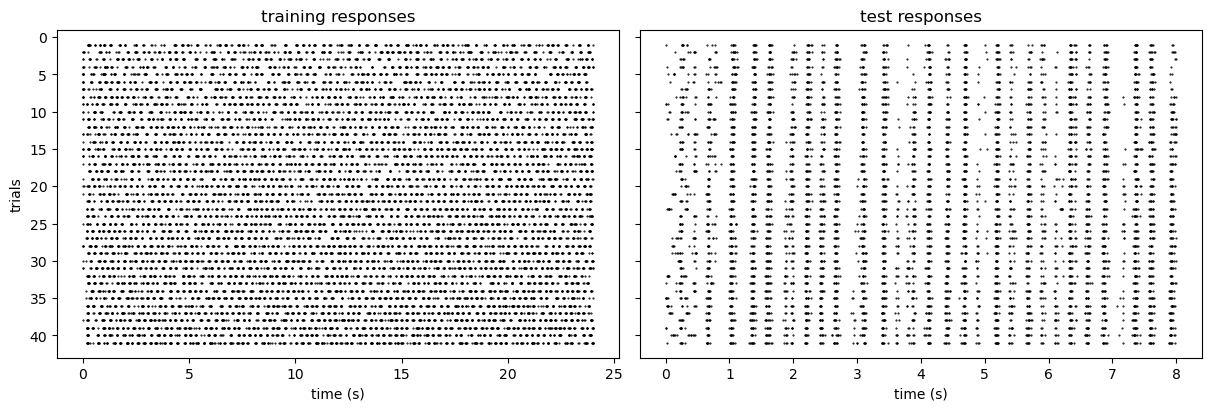

In [23]:
fig, axs = plt.subplots(
    ncols=2, 
    figsize=(12, 4),
    sharex=False,
    sharey=True,
    layout="constrained",
)

axs[0] = plot_rasters(
    response_matrix=training_spikes,
    ax=axs[0],
    sampling_rate=75.,
    c='k',
    marker=".",
    markersize=1.,
    lw=0,
)
axs[0].set_title("training responses")
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("trials")

axs[1] = plot_rasters(
    response_matrix=test_spikes,
    ax=axs[1],
    sampling_rate=75.,
    c='k',
    marker=".",
    markersize=1.,
    lw=0,
)
axs[1].set_title("test responses")
axs[1].set_xlabel("time (s)")

axs[1].invert_yaxis()

plt.show()

**Questions:** What is each dot in these plots? What differences do you notice between the two plots? Why do those differences arise?

# 5 - Wrap things into functions

You are currently working with the responses of a single cell, so it's alright to work with the code we have written above. However, once you begin to work with more cells at the same time, it is much easier if you have your code organized into functions. Functions allow you to repeat your analysis for different inputs without needing to rewrite / modify the core code.

**CAUTION**: you want to avoid giving variables the same names inside and outside the function!

Here is an example in which the reshaping of the stimulus and pulses is wrapped up into one function.

In [24]:
def get_reshaped_stimulus_and_pulses(stimulus_array, pulses_array, training_frames, test_frames):
    """
    Return the stimulus and pulses arrays reshaped to (trials x frames).
    """    
    # compute the total number of trials in the experiment
    frames_per_trial = training_frames + test_frames
    total_trials = int(np.floor(stimulus_array.size / frames_per_trial))
    
    # truncate stimulus and pulses to match the total number of complete trials
    pulses_array = pulses_array[:total_trials * frames_per_trial]
    stimulus_array = stimulus_array[:total_trials * frames_per_trial]
    
    # reshape stimulus and pulses
    pulses_reshaped = np.reshape(pulses_array, (total_trials, frames_per_trial))
    stimulus_reshaped = np.reshape(stimulus_array, (total_trials, frames_per_trial))
    
    return stimulus_reshaped, pulses_reshaped

Here is another example of a more abstract function! It splits a two dimensional array along it's second dimension at a specified location, and returns the smaller arrays. You did this three times in the code so far: once each for the pulses, the stimuli and the spike times. Writing a good general function saves you the effort of re-writing code.

In [25]:
def split_into_two(two_dimensional_array, split_id):
    """
    Split the input 2d-array along its second dimension into two sets at split_id.
    """
    first_array = two_dimensional_array[:, :split_id]
    second_array = two_dimensional_array[:, split_id:]
    
    return first_array, second_array

In [26]:
a, b = split_into_two(reshaped_stimulus, nframes_training)

In [27]:
a.shape  # same shape as training_stimulus

(41, 1800)

In [28]:
b.shape  # same shape as test stimulus

(41, 600)

Now try this out yourself and write functions that do some of the analysis we already did earlier.

**Exercise:** write a function that computes the binned spike times, taking as input a spike time array and the reshaped pulses array.

In [29]:
def compute_binned_spikes(spike_times_array, reshaped_pulses_array):
    
    ## COMPLETE THIS FUNCTION ##
    
    return binned_spike_array

In [30]:
# SOLUTION (same as in code above, the vectorized solution should also work)

def compute_binned_spikes(spike_times_array, reshaped_pulses_array):
    """
    Bin spikes according to the bin edges defined by the pulses.
    """
    binned_spike_array = np.zeros_like(reshaped_pulses_array.ravel(), dtype=int)
    for p in range(1, reshaped_pulses_array.size):
        selected_spikes = spike_times_array[  # select...
            (spike_times_array <= reshaped_pulses_array.ravel()[p]) &  # ... all spiketimes before pulse p
            (spike_times_array >  reshaped_pulses_array.ravel()[p-1])  # ... all spiketimes after pulse p-1
        ]
        binned_spike_array[p-1] = selected_spikes.size
    
    return binned_spike_array

In [31]:
test_output = compute_binned_spikes(stimulus_spiketimes, reshaped_pulses)
assert(np.array_equal(test_output, binned_spikes))  # test if function output matches what you got earlier

# 6 - Collect stimuli before each spike

The spike-triggered average is computed by collecting stimulus values before each spike and averaging them. But how many stimulus values before each spike should be collected? This is determined by a `time_window` parameter.

The `time window` is typically chosen to be between 500ms and 1000ms, depending on the animal model. For our data, 600ms is a good window to choose.

In [32]:
time_window = 0.6  # defined in seconds

What does this mean in terms of number of pulses? The stimulus was presented at a frequency of 75Hz and each prsentation was marked by a pulse. Knowing this, you can calculate the `duration` of each pulse and the number of pulses in a time_window.

**Exercise**: calculate `num_past_pulses` based on `time_window`.

In [33]:
## START CODE HERE##

mean_duration = np.mean(np.diff(pulses))
num_past_pulses = round(time_window / mean_duration)

# OR

num_past_pulses = int(np.floor(time_window * 75))

## END CODE HERE ##

print(num_past_pulses)

45


**Expected output:** `45`

This means that we will have to go `45` frames/values back in time for each spike. However, for the very first spike, probably occuring in the first pulse duration itself, there are no stimulus values back in time. Similarly for all spikes occuring within the first few frames, there are not enough stimulus values back in time.

Thus, we will have to **ignore the first few spikes** for the calculation of STA. More specificially, we will have to **ignore all spikes occurring before the first `num_past_pulses` pulses** in ***each trial***.

**Exercise:** complete the function that takes as input the **binned training spikes, the reshaped stimulus and the number of past frames**, and returns an array with shape (N x `num_past_pulses`), where N is the total number of spikes.

*Hint 1:*  start with an empty list, loop through each trial and each bin, and append past stimulus values to the list for every spike.

*Hint 2:*  for bins with more than 1 spike, append the stimulus snippet twice.

*Hint 3:*  use `enumerate` to write more concise for-loops.

In [34]:
## FILL MISSING PIECES OF THE FUNCTION ##

def get_stimulus_stack(training_spikes_array, training_stimulus, past_frames):
    """
    Extract stimulus values before each spike in the training set, ignoring
    the first past_frames bins.
    """
    snippets = []
    
    for t, trial in enumerate(   ):  # loop over trials
        for b, bin_count in enumerate(   ):  # loop over bins in trial
            # only for bins after first past_frames frames
            if (    ) \
               and (    ):  # and only for bins which have at least 1 spike
                snippet = training_stimulus[
                    
                ]  # cut out past_frames frames before the spike from the stimulus
                for i in range(bin_count):  # append once to list for every spike in bin
                    snippets.append(snippet)
    
    return np.array(snippets)  # return a numpy array

SyntaxError: invalid syntax (3153752094.py, line 17)

In [35]:
## SOLUTION

def get_stimulus_stack(training_spikes_array, training_stimulus, past_frames):
    """
    Extract stimulus values before each spike in the training set, ignoring
    the first past_frames bins.
    """
    snippets = []  # create an empty list
    
    for t, trial in enumerate(training_spikes_array):  # loop over trials
        for b, bin_count in enumerate(trial):  # loop over bins in trial
            # only for bins after first past_frames frames
            if (b + 1 >= past_frames) \
               and (bin_count > 0):  # and only for bins which have at least 1 spike
                snippet = training_stimulus[
                    t, b + 1 - past_frames:b + 1
                ]  # cut out past_frames frames before the spike from the stimulus
                for i in range(bin_count):  # append once to list for every spike in bin
                    snippets.append(snippet)
    
    return np.array(snippets)  # return a numpy array

In [36]:
stimulus_stack = get_stimulus_stack(training_spikes, stimulus_training, num_past_pulses)

In [37]:
print(stimulus_stack.shape)

(16083, 45)


**Expected output:**

```
(16083, 45)
```

How do you know if the first number is the number of spikes? 

In [38]:
training_spikes[:, num_past_pulses-1:].sum()

16083

# 7 - Calculate the STA

Finally, you are ready to calculate the spike-triggered average!! Yoohoo!!

The last step of the process is to compute the average over all the stimulus snippets you extracted in the previous section. So, go ahead and do that!

**Exercise:** take the mean over the first axis of `stimulus_stack` and plot it.

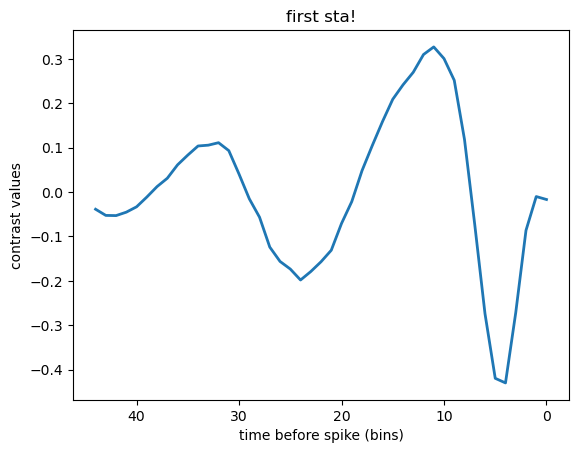

In [39]:
fig, ax = plt.subplots()

## COMPLETE THE FOLLOWING LINE OF CODE ##

sta = stimulus_stack.mean(axis=0)

ax.plot(sta[::-1], lw=2)
ax.set_xlabel("time before spike (bins)")
ax.set_ylabel("contrast values")
ax.set_title("first sta!")
ax.invert_xaxis()
plt.show()

Congratulations! That looks great!

But, what exactly do you see? Do you understand the plot?

The STA is showing us what stimulus the cell "prefers" in the temporal domain. Depending on the data set you have, it might be that the cells prefers decrease and then increase in contrast before spiking; increase and then decrease in contrast; or just increase in contrast. 

You're more or less done with this session!

The last thing you need to do is write a that function wraps up everything we did in this notebook so far.

**Exercise:** complete the function `calculate_sta` that takes as input the original stimuli, pulses, the cell's spiketimes, along with the training and test frame lengths and the num_past_pulses, and returns the sta for that cell. 

You're free to copy code you've written above, and you shouldn't have to write any new code.

In [40]:
def calculate_sta(
    spike_times_array,
    stimulus_array,
    pulses_array, 
    training_frames,
    test_frames,
    past_frames,
):
    """
    Compute a given cell's spike-triggered average (STA) given it's responses to a visual stimulus.
    """
    # reshape the stimulus and pulses using the training_frames and test_frames
    
    
    # select only those spikes which occur during the stimulus presentation
    
    
    # bin the spike train using the reshaped pulses
    
    
    # reshape the binned spikes to the same shape as reshaped_pulses
    
    
    # split spikes into training and test
    
    
    # split stimulus into training and test
    
    
    # get stimulus snippets past_frames before each spike
    
    
    # average over the stimulus snippets
    
    
    
    return sta

In [41]:
def calculate_sta(
    spike_times_array,
    stimulus_array,
    pulses_array, 
    training_frames,
    test_frames,
    past_frames,
):
    """
    Compute a given cell's spike-triggered average (STA) given it's responses to a visual stimulus.
    """
    # reshape the stimulus and pulses using the training_frames and test_frames
    stimulus_reshaped, pulses_reshaped = get_reshaped_stimulus_and_pulses(
        stimulus_array,
        pulses_array,
        training_frames,
        test_frames
    )
    
    # select only those spikes which occur during the stimulus presentation
    spikes_in_stimulus = spike_times_array[  # select...
        (spike_times_array > pulses_reshaped.ravel()[0]) &  # ... all spikes after the first pulse
        (spike_times_array < pulses_reshaped.ravel()[-1])  # ... and all spikes before the last pulse
    ]
    
    # bin the spike train using the reshaped pulses
    spikes_binned = compute_binned_spikes(
        spikes_in_stimulus,
        pulses_reshaped
    )
    
    # reshape the binned spikes to the same shape as reshaped_pulses
    spikes_in_trials = np.reshape(spikes_binned, reshaped_pulses.shape)
    
    # split spikes into training and test
    training_spikes, _ = split_into_two(
        spikes_in_trials,
        training_frames
    )
    
    # split stimulus into training and test
    training_stimulus, _ = split_into_two(
        stimulus_reshaped,
        training_frames
    )
    
    # get stimulus snippets past_frames before each spike
    stimulus_snippets = get_stimulus_stack(
        training_spikes,
        training_stimulus,
        past_frames
    )
    
    # average over the stimulus snippets
    sta = stimulus_snippets.mean(axis=0)
    
    return sta

In [42]:
test_sta = calculate_sta(
    spike_times,
    stimulus,
    pulses,
    nframes_training,
    nframes_test,
    num_past_pulses
)

print(np.array_equal(sta, test_sta))

True


**Expected output:** True

# 8. Compare multiple cells

So far, we calculated the STA of one example cell. However, different cells can have very different STAs. The shape of the STA usually depends on the cell-type (ON-cell, OFF-cell etc.).

Let us look at a few more cells and examine the differences between their STAs.

In [43]:
stas = []

filepaths = sorted(Path('data_LN_model').glob('fullfieldnoise*.txt'))

for filepath in filepaths:
    spike_times = np.loadtxt(filepath)
    sta = calculate_sta(
        spike_times,
        stimulus,
        pulses,
        nframes_training,
        nframes_test,
        num_past_pulses
    )
    stas.append(sta)

stas = np.array(stas)

In [44]:
stas.shape

(8, 45)

The array `stas` now contains the stas of 8 cells. Let us plot them and see what they look like.

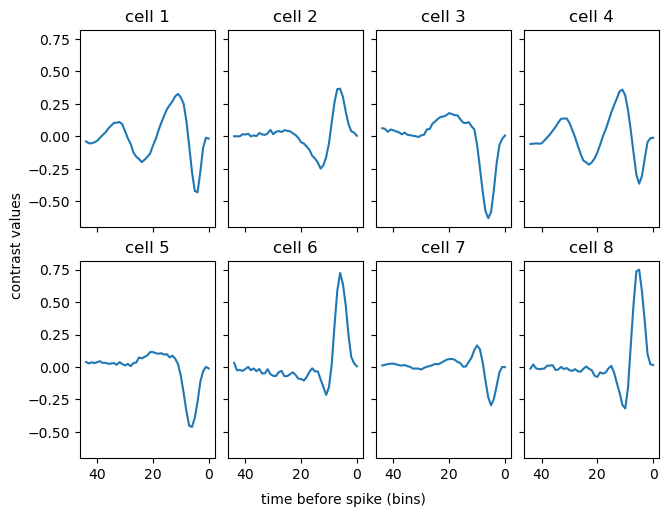

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, layout="constrained", figsize=(12,)

for s, sta in enumerate(stas):
    ax = axs.flat[s]
    ax.plot(sta[::-1])
    ax.set_title(f"cell {s+1}")

axs.flat[-1].invert_xaxis()
fig.text(0.5, -0.03, "time before spike (bins)", ha="center", va="center")
fig.text(-0.01, 0.5, "contrast values", ha="center", va="center", rotation="vertical")
plt.show()